In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 sample_submission.csv	X_val.npy
custom_fast_text_embeddings.npy  SelfAttention.py	y_test.npy
datalab				 train_model.py		y_train_full.npy
fast_text_embeddings.npy	 X_submission.npy	y_train.npy
plot_history.py			 X_test.npy		y_val.npy
__pycache__			 X_train_full.npy
roc_auc_callback.py		 X_train.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'15j1Nou6m5WNLejJQrUcty6U03xsIgIAI'})
file_import.GetContentFile('SelfAttention.py') 

from SelfAttention import SelfAttention

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def single_category_regressor(features, unitsNumber = 64):
    dense_1 = Dense(unitsNumber, activation = 'elu')(features)
    dense_1_normalization = BatchNormalization()(dense_1)
    dense_1_dropout = Dropout(0.2)(dense_1_normalization)

    dense_2 = Dense(unitsNumber, activation = 'elu')(dense_1_dropout)
    dense_2_normalization = BatchNormalization()(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2_normalization)
    
    return Dense(1, activation='sigmoid')(dense_2_dropout)

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

embedding_dropout = SelfAttention()(embedding_dropout)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor(filtersNumber, features_3)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

single_category_layer = concatenate([
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
])

output_layer = average([output_layer, single_category_layer])

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 19808/102124 [====>.........................] - ETA: 9:22 - loss: 0.1967 - acc: 0.9211 54848/102124 [===============>..............] - ETA: 5:00 - loss: 0.1220 - acc: 0.9531 89280/102124 [=========================>....] - ETA: 1:20 - loss: 0.1031 - acc: 0.9608102124/102124 [==============================] - 678s 7ms/step - loss: 0.0988 - acc: 0.9626 - val_loss: 0.0802 - val_acc: 0.9753
Epoch 2/32
  8256/102124 [=>............................] - ETA: 9:30 - loss: 0.0649 - acc: 0.9762 41056/102124 [===========>..................] - ETA: 6:16 - loss: 0.0652 - acc: 0.9765 74432/102124 [====================>.........] - ETA: 2:50 - loss: 0.0646 - acc: 0.9768102124/102124 [==============================] - 668s 7ms/step - loss: 0.0634 - acc: 0.9772 - val_loss: 0.0850 - val_acc: 0.9706
roc-auc: 0.9702 - roc-auc_val: 0.9684                                                                                                    
Epoch 3/3

  1888/102124 [..............................] - ETA: 10:16 - loss: 0.0432 - acc: 0.9829 36992/102124 [=========>....................] - ETA: 6:38 - loss: 0.0408 - acc: 0.9837 71392/102124 [===================>..........] - ETA: 3:07 - loss: 0.0410 - acc: 0.9838102124/102124 [==============================] - 664s 7ms/step - loss: 0.0412 - acc: 0.9837 - val_loss: 0.0416 - val_acc: 0.9837
Epoch 18/32
  1344/102124 [..............................] - ETA: 10:17 - loss: 0.0401 - acc: 0.9833 35104/102124 [=========>....................] - ETA: 6:50 - loss: 0.0403 - acc: 0.9840 69184/102124 [===================>..........] - ETA: 3:22 - loss: 0.0408 - acc: 0.9837102124/102124 [==============================] - 666s 7ms/step - loss: 0.0409 - acc: 0.9838 - val_loss: 0.0438 - val_acc: 0.9836
roc-auc: 0.9901 - roc-auc_val: 0.983                                                                                                    
Epoch 19/32
   128/102124 [..............................] - ETA: 10:

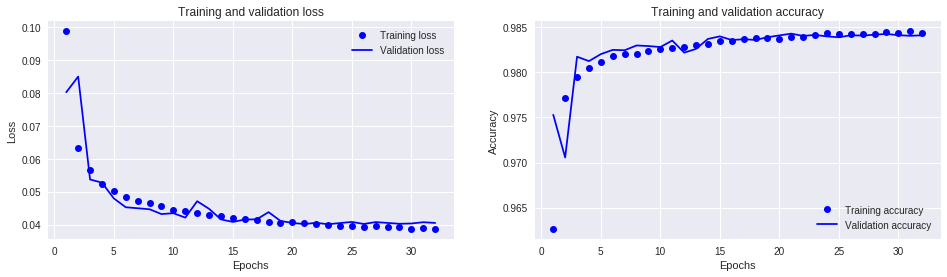

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 54s 2ms/step
([0.0385048417558626, 0.9846675929820745], 0.9887902222753547)


Medium batch size training

In [0]:
history = train_with_cv(model, batchSize=64, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 42816/102124 [===========>..................] - ETA: 5:05 - loss: 0.1709 - acc: 0.9300102124/102124 [==============================] - 548s 5ms/step - loss: 0.1138 - acc: 0.9556 - val_loss: 0.0701 - val_acc: 0.9792
Epoch 2/32
  5440/102124 [>.............................] - ETA: 7:55 - loss: 0.0658 - acc: 0.9763102080/102124 [============================>.] - ETA: 0s - loss: 0.0630 - acc: 0.9769102124/102124 [==============================] - 538s 5ms/step - loss: 0.0630 - acc: 0.9769 - val_loss: 0.0549 - val_acc: 0.9794
roc-auc: 0.9763 - roc-auc_val: 0.9735                                                                                                    
Epoch 3/32
102124/102124 [==============================] - 543s 5ms/step - loss: 0.0565 - acc: 0.9789 - val_loss: 0.0527 - val_acc: 0.9808==>.] - ETA: 0s - loss: 0.0565 - acc: 0.978
Epoch 4/32
 20352/102124 [====>.........................] - ETA: 6:46 - loss: 0.0519 - ac

102124/102124 [==============================] - 535s 5ms/step - loss: 0.0360 - acc: 0.9854 - val_loss: 0.0406 - val_acc: 0.9847==>.] - ETA: 0s - loss: 0.0360 - acc: 0.985
Epoch 28/32
 20288/102124 [====>.........................] - ETA: 6:39 - loss: 0.0354 - acc: 0.9855102080/102124 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9853102124/102124 [==============================] - 534s 5ms/step - loss: 0.0360 - acc: 0.9853 - val_loss: 0.0403 - val_acc: 0.9847
roc-auc: 0.9958 - roc-auc_val: 0.9866                                                                                                    
Epoch 29/32
102124/102124 [==============================] - 533s 5ms/step - loss: 0.0356 - acc: 0.9852 - val_loss: 0.0409 - val_acc: 0.9848==>.] - ETA: 0s - loss: 0.0356 - acc: 0.985

Epoch 00029: ReduceLROnPlateau reducing learning rate to 2.7204705475014634e-05.
Epoch 30/32
 16000/102124 [===>..........................] - ETA: 6:59 - loss: 0.0355 - acc: 0.9854 23552/10212

In [0]:
plot_history(history)

In [0]:
print(evaluate_on_test(model))